In [1]:
import torch
from torch import nn
from torch import optim

In [166]:
class UniNN(nn.Module):
    def __init__(self, hidden):
        super(UniNN, self).__init__()
        self.device = "cpu"
        if hidden > 500:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.hidden = hidden       
        self.fc1 = nn.Linear(1, self.hidden)
        self.dropout = nn.Dropout(p=0.1)
        #self.batch_norm = nn.BatchNorm1d(self.hidden)
        self.activation = nn.ReLU()                     
        self.fc2 = nn.Linear(self.hidden, 1)
        self.test_loss_reached = False
        self.end_test_loss = 0         

    def forward(self, x):
        out_1 = self.fc1(x.to(self.device))
        out_drop = self.dropout(out_1)
        out_act = self.activation(out_drop)
        return self.fc2(out_act)

    def get_dataloader(self,f,num_samples=5000, batch_size = 32):
        X = torch.vstack((torch.rand(num_samples, 1), torch.zeros(num_samples //20 ,1)))
        train_dataset = torch.utils.data.TensorDataset(X, f(X))
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        return train_dataloader

    def fit(self, dataloader, dataloader_test, epochs=100, lr=0.001, decay = 1e-3, B = 10):
        self.to(self.device)
        criterion = nn.MSELoss()
        optimizer = optim.RAdam(self.parameters(), lr=lr, weight_decay=0)
        train_losses = []
        test_losses = []
        iters = 0
        epoch = 0
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=333, gamma=0.1)
        while True:
            epoch += 1
            self.train()
            running_train_loss = 0.0
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                overall_loss = loss
                optimizer.zero_grad()
                overall_loss.backward()
                optimizer.step()
                running_train_loss += loss.item()
                self.project(B)
            avg_train_loss = running_train_loss / len(dataloader)
            train_losses.append(avg_train_loss)
            self.eval() 
            running_test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in dataloader_test:
                    outputs = self(inputs.to(self.device))
                    loss = criterion(outputs, labels.to(self.device))
                    running_test_loss += loss.item()
            avg_test_loss = running_test_loss / len(dataloader_test)
            test_losses.append(avg_test_loss)
            if avg_test_loss < 5e-3:
                iters += 1
            else:
                iters = 0
            if iters == 10:
                self.test_loss_reached = True
                
            #print(f""" Epoch:{epoch}, trainloss:{avg_train_loss}, testloss:{avg_test_loss}, lr = {optimizer.param_groups[0]["lr"]}""")
            scheduler.step()
            #if optimizer.param_groups[0]["lr"] < 2e-5:
            #    self.test_loss_reached = False
            #    break
            if epoch > 1000:
                break
            #
            #print(self.L)
        self.compute_lipschitz_constant()
        self.end_test_loss = sum(test_losses[-5:]) / 5
        self.end_train_loss = sum(train_losses[-5:]) / 5  
        self.model_err_sup_norm()
        print(self.hidden, B,self.L, self.test_loss_reached, test_losses[-5:])
        return test_losses

    def project(self,B):
        names = []
        for name, param in self.named_parameters():
            if ('weight' in name): 
                norm = torch.linalg.matrix_norm(param, ord = float('inf'))
                if (norm > B):
                #print(param, "prev", param.data.norm(2) )
                    param.data /= norm
                    param.data *= B
                #names.append(name)
                #print("projected")

        #for name, param in self.named_parameters():
        #   if (name in names):
        #        print(param, "after")
        #        print(torch.linalg.vector_norm(param.flatten(), ord = 2))

        

    def plot_model(self, f, title):
        x_train = torch.linspace(0,1,1000)
        with torch.no_grad():
            y_pred = self(x_train.view(-1,1))
        print("estimated_sup_norm_error", torch.max(torch.abs(y_pred.view(-1) - f(x_train))))
        plt.plot(x_train.numpy(), y_pred.numpy(), label="Model")
        plt.plot(x_train.numpy(), f(x_train).numpy(), label="Objective")
        plt.title("Model Predictions vs Data" + ' decay:' + title)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()

    def reg(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss += torch.linalg.matrix_norm(param, ord = 1)
        return reg_loss

    def model_err_sup_norm(self):
        x_train = torch.linspace(0,1,1000)
        with torch.no_grad():
            y_pred = model(x_train.view(-1,1)).to("cpu")
        self.sup_err = torch.max(torch.abs(y_pred.view(-1) - f(x_train)))

    def compute_lipschitz_constant(self):
        self.L = 1
        for name, param in self.named_parameters():
            if 'weight' in name:
                self.L *= torch.linalg.matrix_norm(param, ord = float('inf'))
        

In [167]:
def f(X):
    return X**0.23

In [137]:
import dill
with open("models_projected.dill", "wb") as file:
    dill.dump(models, file)

In [168]:
model = UniNN(16)
dataloader_train = model.get_dataloader(f)
dataloader_test = model.get_dataloader(f, num_samples=200)
models = {}
Bs = [2,4,100000000] 
#Bs = [2]
#decays = [1e-2]
for i in range(12):
    diction = {2**i: []}
    for B in Bs:
        model = UniNN(2**i)
        loss = model.fit(lr = 1e-3, dataloader=dataloader_train, dataloader_test=dataloader_test, decay=decay, B = B)
        diction[2**i].append(model)
    models.update(diction)

1 2 tensor(0.1166, grad_fn=<MulBackward0>) False [0.05094793305865356, 0.050281653978994915, 0.05089376707162176, 0.052838732089315145, 0.050957015582493374]
1 4 tensor(0.4669, grad_fn=<MulBackward0>) False [0.017585235315241983, 0.017525216531274573, 0.016426316495718702, 0.018631609988265803, 0.017760370026475618]
1 100000000 tensor(0.0144, grad_fn=<MulBackward0>) False [0.05125768216592925, 0.05093415853168283, 0.05315527479563441, 0.054579754759158404, 0.05263872391411236]
2 2 tensor(0.5944, grad_fn=<MulBackward0>) False [0.05428746156394482, 0.05060922221413681, 0.05022025055118969, 0.05078876151570252, 0.05277675549898829]
2 4 tensor(8.5968, grad_fn=<MulBackward0>) True [0.0027496254104854806, 0.0025795347589467254, 0.002659512683749199, 0.002532987223405923, 0.002640161314047873]
2 100000000 tensor(0.8231, grad_fn=<MulBackward0>) False [0.01659847536523427, 0.01645155081392399, 0.018528133763798645, 0.01667996994884951, 0.017460282492850508]
4 2 tensor(1.5460, grad_fn=<MulBackwa

In [131]:
Bs = [2,8,100000000] 
for i in range(3,14):
    diction = {2**i: []}
    for B in Bs:
        model = UniNN(2**i)
        loss = model.fit(lr = 1e-3, dataloader=dataloader_train, dataloader_test=dataloader_test, decay=decay, B = B)
        diction[2**i].append(model)
    models.update(diction)

RuntimeError: linalg.matrix_norm: The input tensor A must have at least 2 dimensions.

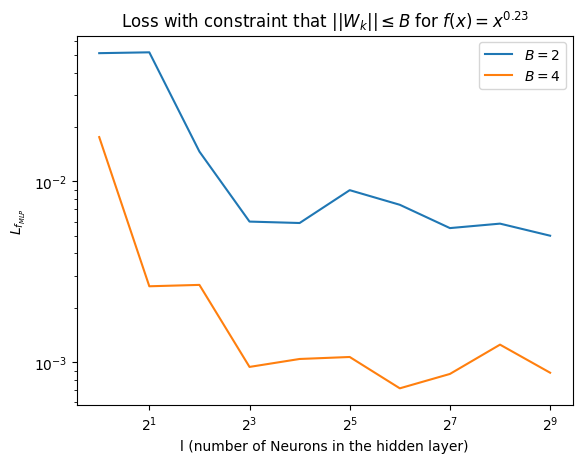

In [175]:
import matplotlib.pyplot as plt
for j,B in enumerate(Bs):
    if j == 2:
        continue
    Err = []
    Neurons = []
    for i in range(10):
        #Err.append(models[2**i][j].end_train_loss)
        Err.append(models[2**i][j].end_test_loss)
        Neurons.append(2**i)
    if B > 100:
        plt.plot(Neurons,Err, label = r"$B = $" + r"$\infty$")
    else:
        plt.plot(Neurons,Err, label = r"$B = $" + f"{B}")
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel("l (number of Neurons in the hidden layer)")
plt.ylabel(r"$L_{f_{MLP}}$")
plt.title(r"Loss with constraint that $||W_k|| \leq B$ for $f(x) = x^{0.23}$")
plt.legend()
plt.show()

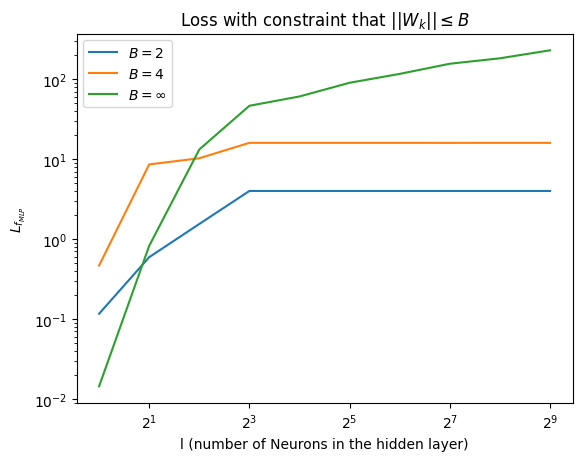

In [173]:
import matplotlib.pyplot as plt
for j,B in enumerate(Bs):
    #if B == 1:
    #    continue
    Err = []
    Neurons = []
    for i in range(10):
        Err.append(models[2**i][j].L.item())
        Neurons.append(2**i)
    if B > 100:
        plt.plot(Neurons,Err, label = r"$B = $" + r"$\infty$")
    else:
        plt.plot(Neurons,Err, label = r"$B = $" + f"{B}")
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel("l (number of Neurons in the hidden layer)")
plt.ylabel(r"$L_{f_{MLP}}$")
plt.title(r"Loss with constraint that $||W_k|| \leq B$")
plt.legend()
plt.show()